# Using Unsupervised Machine Learning (Latent Dirchlet Allocation) for Topic Extraction and Sentiment Prediction
  
### Kyle Beloin

# Part 1: Brief Summary of Project and Research Question

### This notebook is the culmination of a fairly large data collection process, and seeks to derive significant topics from Yelp reviews collected between the times: April 2020 to September 2020. 
  
  
The goal of this project is to explore topic modeling through Yelp data. My research question is two-fold:
  
1. Can topics derived from LDA be a reliable predictor for sentiment?
2. Do the order of topics in individual reviews covary?

## 1.1: Data Exploration and building the model

In [ ]:
from time import time
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk import word_tokenize
from sklearn.utils import resample
import seaborn as sns
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [ ]:


def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('_', ' ', text)
    return text

def stem_text(text, func):
    text = word_tokenize(text)
    
    l_text = [func.stem(x) for x in text]
    
    text = ' '.join(l_text)
    return text

def get_stops():
    ''' This function builds a list of stopwords from nltk corpora: stopwords, and food list'''
    from nltk.corpus import wordnet as wn
    food = wn.synset('food.n.02')
    food_words= list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
    stops = stopwords.words('english')
    stops = set(stops)
    for word in food_words: stops.add(clean_text_round1(word))    
    return stops

def remove_stop_words(text, stops):
    tokens = set(word_tokenize(text.lower()))
    new_text = tokens - stops
    
    tokens = word_tokenize(text)
    text = [token for token in tokens if token not in new_text]
    return text

def language(text): # in original data cleaning, I used this function to extract only english reviews.
    '''Detects language of given string '''
    try:
        lang = detect(text)
        return lang
    except:
        return None
    
def combine_text(text):
    '''Takes a list of text and combines them into large chunk of text'''
    combined_text = ' '.join(text)
    return combined_text

def print_top_words(model, feature_names, n_top_words):
    '''Print top words from LDA model'''
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print('\n')
        print(message)
    print()

def top_words_dict(model, feature_names, n_top_words):
    '''Derives feature names for top-n words'''
    dic = {}
    for topic_idx, topic in enumerate(model.components_):
        dic[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    
    return dic

stops = set()
for phrase in get_stops():
    for word in word_tokenize(phrase):
        stops.add(word)

The data used in this notebook was scraped and cleaned using custom scraping and regex code. That can be found in an attached notebook that is available upon request. 

## Importing Datasets

In [4]:
post = pd.read_csv('./data/yelp_post_covid.csv')
post = post.iloc[:,1:]
# remove old indices
post.head()

,dates,pricerange,stars,reviews,word_count,vader_pos,vader_neg,vader_neu,vader_compound
0,2020-07-30,1,1,We ordered the pizza and wing special through ...,105,0.017,0.078,0.905,-0.7814
1,2020-07-25,1,1,I ordered from this place. I spent 45.00. I or...,77,0.047,0.163,0.791,-0.8827
2,2020-06-12,1,4,I got the meat lovers deep dish pizza (Sicilia...,34,0.362,0.000,0.638,0.9516
3,2020-07-06,1,4,"Friendly staff, excellent food, and great pric...",62,0.219,0.052,0.729,0.8779
4,2020-08-21,1,5,"The shop is amazing, it has donuts, cupcakes, ...",63,0.312,0.024,0.663,0.9617


The data consists of several columns; the relevant ones here will be: stars, sentiment score (vader_compound), and reviews. To see how the sentiment score was calculated, check out: https://pypi.org/project/vaderSentiment/

An initial look at the distribution of our data shows that the "five star" and "one star" rating is overpresented in our data. This conclusion makes sense, as folks are more likely to leave reviews if they're either extrememly upset or very happy. 

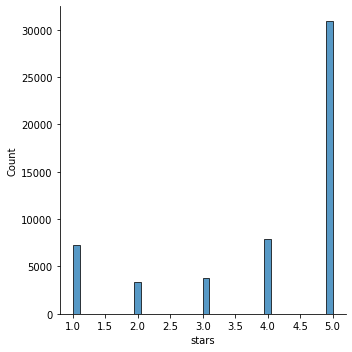

In [26]:
sns.displot(post.stars)

In [27]:
post.stars.value_counts()

5    30919
4     7912
1     7295
3     3774
2     3398
Name: stars, dtype: int64

This skew is similar when looking at sentiment. Below, we can see that the distribution positive sentiment far outweighs that of others--and negative sentiment is still higher than neutral. Of course, this skew also makes sense considering the nature of internet speak and the way VADER sentiment is calculated (takes into account capitalization).

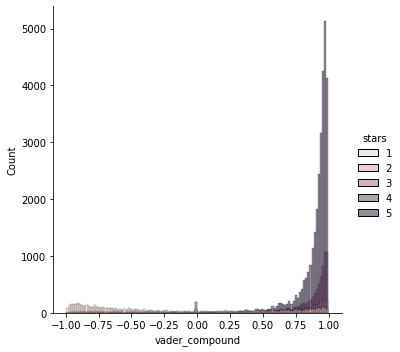

In [28]:
sns.displot(post, x='vader_compound', hue='stars')

To adjust for some of this skewed data, and to ensure that our topics don't capture words related to sentiment opposed to asentimental/objective groupings, we can build into our data conditions. 

In [16]:
# only look at reviews that aren't overly positive
post = post[post.vader_compound < .90]

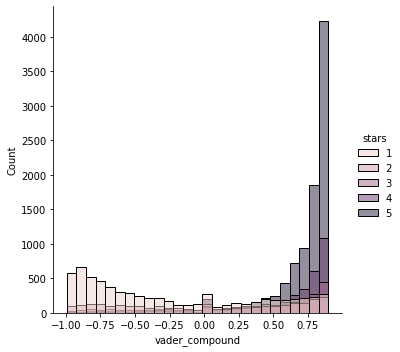

In [18]:
sns.displot(post, x='vader_compound', hue='stars')

Even with these adjustments, it's clear there are several groups here. It may be worth separating them out to get at the topics at hand. 

In [29]:
ones = post[post.stars == 1]
ones.reset_index(drop=True, inplace=True)
twos = post[post.stars == 2]
twos.reset_index(drop=True, inplace=True)
threes = post[post.stars == 3]
threes.reset_index(drop=True, inplace=True)
fours = post[post.stars == 4]
fours.reset_index(drop=True, inplace=True)
fives = post[post.stars == 5]
fives.reset_index(drop=True, inplace=True)

We can try to resample the results around star rating. We can use the 'resample' function from sklearn to achieve this. 

In [155]:
n = 2000
ones = resample(ones, replace = False, n_samples=n,random_state = 0)
twos = resample(twos, replace = False, n_samples=n, random_state = 0)
threes = resample(threes,replace = False, n_samples=n,random_state = 0)
fours = resample(fours, replace = False,n_samples=n,random_state = 0)
fives = resample(fives, replace = False,n_samples=n, random_state = 0)

After the new random resamples are extracted, we can concat to make a new dataframe (that will hopefully be better distributed).

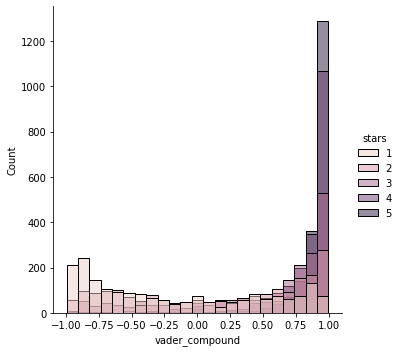

In [156]:
post_strat = pd.concat([ones, twos, threes, fours, fives])
sns.displot(post_strat, x='vader_compound', hue='stars')

While the plot is still skewed, it's clear that the star ratings are better distributed along sentiment. However, this may come back later if we see star ratings being predicted by sentiment instead of topic. 

Before building the model, we can apply some initial rounds of cleaning. My cleaning includes three steps:
1. Typical text cleaning, such as removing punctuation, numbers, etc.
  
2. Stemming text, so that 'reading', 'reads' and 'read' are all represented as 'read'. 
  
3. Removing (and identifying) stop words. Part of this process involves removing words that pertain to food specifically, as they tend to group reviews around cuisine.

In [97]:
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('_', ' ', text)
    return text



def stem_text(text, func):
    text = word_tokenize(text)
    
    l_text = [func.stem(x) for x in text]
    
    text = ' '.join(l_text)
    return text


def remove_stop_words(text, stops):
    tokens = set(word_tokenize(text.lower()))
    new_text = tokens - stops
    
    tokens = word_tokenize(text)
    text = ' '.join([token for token in tokens if token in new_text])
    return text

In [65]:
round1 = lambda x: clean_text_round1(x)
round2 = lambda x: stem_text(x, stemmer)
round3 = lambda x: remove_stop_words(x, stops)

Let's have an initial look at our reviews.

In [93]:
for review in post_strat.reviews.head(): print (review, '\n')

First I have to say Antonio's is one of my favorites but since the Covid 19 lockdown we have not been ordering from anywhere but today decided we needed pizza and after reading the Covid safety precautions on their website ordered from the Medina location. Went in to pick up my pizza (wearing a mask and gloves) and the guy in the back told me someone would be there in a minute. Noticed he was making the pizzas and wearing gloves and a mask. A young lady came to the front to wait on me with her mask down around her chin, wearing no gloves but to make it worse the second guy that came out and was preparing food was not even wearing a mask or gloves. I want to support local businesses and Antonio's is one I have supported for years but don't write how you are taking every precaution for this unrepresented time on your website and then not carry them out in your stores. Sorry I won't be back 

I have ordered several times successfully before yesterday which gave me confidence that I would 

Let's apply the first round of cleaning, and check out the results.

In [242]:
reviews = pd.DataFrame(post_strat.reviews.apply(round1))
for review in reviews.reviews.head(): print (review, '\n')

first in line waiting for  min  parties behind me on the waiting list and they let in the very last party a party of  in before anyone elsei checked in online for a reason dont come here they dont value their customers  

this is how i received my firer crackers wont be going anymore there was a rush n cashier was rude 

disgusting i ordered a veggie roti and the amount of hair i found in my food is criminal i still cant even fathom that someone packaged this if i ordered a roti why are you sending me hair 

very poor customer service plenty of better options in toronto without the hate 

where should i get started worker at the front was in the kitchen for a long time and made me wait cause no one was able to take my order then when i got my tacos it was very dissatisfying the presentation they wrapped them like a burrito and the carne asada was cut in long strips like fajita no flavor chewy meat and they dont give you limes radishes cucumbers salsas free of charge like backyard taco 

### Next is stemming, which will make words like "read", "reads" and "reading" group all be: 'read'

In [98]:
reviews = pd.DataFrame(reviews.reviews.apply(round2))
for review in reviews.reviews.head(): print (review, '\n')

first i have to say antonio is one of my favorit but sinc the covid lockdown we have not been order from anywher but today decid we need pizza and after read the covid safeti precaut on their websit order from the medina locat went in to pick up my pizza wear a mask and glove and the guy in the back told me someon would be there in a minut notic he was make the pizza and wear glove and a mask a young ladi came to the front to wait on me with her mask down around her chin wear no glove but to make it wors the second guy that came out and was prepar food was not even wear a mask or glove i want to support local busi and antonio is one i have support for year but dont write how you are take everi precaut for this unrepres time on your websit and then not carri them out in your store sorri i wont be back 

i have order sever time success before yesterday which gave me confid that i would be pleas again yesterday that turn out not to be the case i order white with fri and a larg okra throug

### While the words are odd looking, it will allow for more consistent grouping. Let's see what happens when we remove stop words. 



In [99]:
reviews= pd.DataFrame(reviews.reviews.apply(round3))
for review in reviews.reviews.head(): print (review, '\n')

first say antonio one favorit sinc covid lockdown order anywher today decid pizza read covid safeti precaut websit order medina locat went pick pizza wear mask glove guy back told someon minut notic make pizza wear glove mask young ladi came front wait mask around chin wear glove make wors second guy came prepar even wear mask glove want support local busi antonio one support year dont write take everi precaut unrepres time websit carri sorri wont back 

order sever time success yesterday gave confid pleas yesterday turn order fri larg doordash order arriv earli surpris contain one fri call restaur inform happen provid order number young spoke said oh stake sorri went tell avail remedi credit portion payment back card come pick total unaccept want pickup done feel like respons deliv rest order young spoke told possibl asid deliv via doordash employ deliveri driver someth correct order deliveri portion neglect includ deliveri longer spend dollar know mistak happen restaur differ correct

In [174]:
# finally, let's save a new column on our dataframe
post_strat['text'] = reviews

# Part 3: The Algorithm

## Latent Dirchlet Allocation: A "Bag of Words" Approach to Topic Extraction

Latent Dirchlet Allocation (LDA) is an unsupervised machine learning technique that essentially 'sorts' obervations based on their relative vector distance to one another. A basic example can be seen with the following sentences:
  
"The cat ate kale"
  
"Kale is a vegetable"
  
"Cats are fluffy!"
  
If we were to pick two topics here, we might say they are "cats" and "kale"; or more broadly, 'pets' and 'vegetables'.  Furthermore, we might say that statement one is 50% cat and 50% kale; statement two is 100% kale, and statement three is 100% cat. 
  
LDA essentially allows us to accomplish this with ticket descriptions; however, they must first be represented numerically. One option for this is "Term-Frequency inverse document frequency", or 'tf-idf', which allocates values to tokens (words) based on their frequency within and across ticket descriptions. In this case, very commmon words would be weighted lightly, while uncommon words that appear across several reviews would be rated heavily. The code for each of those algorithms is included below. 

<i>Special thanks to Alice Zhao and her excellent YouTube channel for helping me here.</i>

In [191]:
from sklearn.decomposition import LatentDirichletAllocation
# borrowed from sklearn's documentation. 
def get_LDA(df, n_features=5000, n_components=10, n_top_words=30, iterations = 25):
    df.reset_index(drop=True, inplace=True)

    data_samples = list(df.text.T.values)
    vectorizer = TfidfVectorizer(max_df=.90, min_df=.025,
                                   max_features=n_features, binary=False, sublinear_tf=False,
                                 
                                   stop_words=stops,ngram_range=(1,2), smooth_idf=True)
    
    tfidf = vectorizer.fit_transform(data_samples)
    
    tdm = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
    
    lda = LatentDirichletAllocation(n_components=n_components, random_state=0,
          max_iter=iterations).fit(tdm)
    
    tfidf_feature_names = vectorizer.get_feature_names()
    print_top_words(lda, tfidf_feature_names, n_top_words)
    top_n = top_words_dict(lda, tfidf_feature_names, 30)
    
    H = pd.DataFrame(lda.components_, columns = vectorizer.get_feature_names())
    W = pd.DataFrame(lda.transform(tdm))
    X = tdm.copy()
    
    return {'models':(lda, vectorizer),'data':(df, X, H, W,tfidf), 'topics': top_n}
    

In [106]:
d = get_LDA(post_strat, 1000, 8, 30)



Topic #0: order tast like sauc good dish flavor fri place tri one got noodl disappoint dri cook time restaur piec eat also spici thai soup get tast like chee realli wasnt dont


Topic #1: go place ive back good sushi best come time ever tri im alway get order great ice one love servic definit like realli live spot price go back make ill use


Topic #2: order call custom time rude ask servic phone wait custom servic didnt get place said never pick told minut got back go take busi dont even onlin charg hour went good


Topic #3: pizza taco great order excel best burrito local good wing place amaz qualiti price sauc support deliveri servic tri better chee love favorit thank take delici go offer recommend time


Topic #4: good burger pretti realli fri price realli good place pretti good worth littl like order tast got get portion great servic flavor nice tri go decent beer chee wing small size also


Topic #5: tabl us server wait seat drink order came time good servic place get ask resta

#### We can look more closely at these topics, and see if we can derive some sense from them. 
  
#### Importantly, it's topic #7 that points us to the covid terms, such as: mask, wear, social distance, etc. 

The term document matrix (tdm)from our LDA will return each statement with a value that determines how strongly each topic influenced it's grouping. 

In [110]:
tdm = d['data'][3]
tdm.head()

,0,1,2,3,4,5,6,7
0,0.019901,0.019904,0.019926,0.019961,0.019895,0.019912,0.019906,0.860595
1,0.020774,0.020748,0.854690,0.020760,0.020785,0.020744,0.020751,0.020747
2,0.794845,0.029325,0.029302,0.029292,0.029303,0.029310,0.029313,0.029311
3,0.834539,0.023640,0.023645,0.023629,0.023631,0.023644,0.023638,0.023635
4,0.052311,0.052394,0.633294,0.052396,0.052292,0.052283,0.052687,0.052344


#### If we look at the first statement, it seems to be strongly influenced by topic #7. Let's see if our first review talks about COVID...

In [113]:
post_strat.iloc[0].reviews

"First I have to say Antonio's is one of my favorites but since the Covid 19 lockdown we have not been ordering from anywhere but today decided we needed pizza and after reading the Covid safety precautions on their website ordered from the Medina location. Went in to pick up my pizza (wearing a mask and gloves) and the guy in the back told me someone would be there in a minute. Noticed he was making the pizzas and wearing gloves and a mask. A young lady came to the front to wait on me with her mask down around her chin, wearing no gloves but to make it worse the second guy that came out and was preparing food was not even wearing a mask or gloves. I want to support local businesses and Antonio's is one I have supported for years but don't write how you are taking every precaution for this unrepresented time on your website and then not carry them out in your stores. Sorry I won't be back"

#### This seems right! Let's try to see if the top 5 reviews confirm this grouping...

In [128]:
# Grab covid column
covid_topic = tdm.iloc[:,7]
# sort values
covid_topic.sort_values().tail().index

Int64Index([4360, 5329, 5775, 5781, 190], dtype='int64')

We have our top five, now let's index on the DataFrame:

In [134]:
i = covid_topic.sort_values().tail().index.values

for review in post_strat.iloc[i].text: print (review, '\n')

medit post day decid say peac love restaur custom servic sometim lack kept come back sinc open howev return eat start mandat face mask second time visit singl employ mask ncs govern face mask mandat went effect past friday order take yesterday walk pick mask notic sign door ask patron wear mask cour small counter facemask woman poke kitchen window talk shield front regist made feel somewhat safer least enough accept go order howev wait order complet one two women walk neither face mask singl word said employ counter know lot peopl think pandem joke ys love one pass away due complic governor mandat effect name restaur place face mask worn employ custom except still wont enforc mandat wont back continu tell peopl wont back let decid want take risk im disappoint establish better peopl 

medit post day decid say peac love restaur custom servic sometim lack kept come back sinc open howev return eat start mandat face mask second time visit singl employ mask ncs govern face mask mandat went e

### Interesting--it appears there are several duplicate reviews in our data! Let's see if we can remove them by using unique.

In [140]:
for review in post_strat.iloc[i].text.unique(): print (review, '\n')

medit post day decid say peac love restaur custom servic sometim lack kept come back sinc open howev return eat start mandat face mask second time visit singl employ mask ncs govern face mask mandat went effect past friday order take yesterday walk pick mask notic sign door ask patron wear mask cour small counter facemask woman poke kitchen window talk shield front regist made feel somewhat safer least enough accept go order howev wait order complet one two women walk neither face mask singl word said employ counter know lot peopl think pandem joke ys love one pass away due complic governor mandat effect name restaur place face mask worn employ custom except still wont enforc mandat wont back continu tell peopl wont back let decid want take risk im disappoint establish better peopl 

ive hesit past coupl day write review review may help hope think twice come restur start came enjoy weekend work walk one server acknowledg minut hostess take order phone gave shot due hear great older lad

### Indeed, it seems using unique does reduce the reviews to the appropriate amount. Let's apply this to the whole data set. We can do this using 'drop_duplicates' and passing in the 'text' field 

In [147]:
post_strat = post_strat.drop_duplicates(subset='text')
post_strat.shape

(5022, 11)

### Amazing! Our data was nearly cut in half. How are our distributions looking?

In [154]:
post_strat.stars.value_counts()

5    1083
4    1025
1    1022
3     960
2     932
Name: stars, dtype: int64

### Interestingly, our star counts have dropped drastically. It seems we were resampling with replacement. Let's try to resample without replacing to see if we get different results. Unfortunately, we'll have to run the code all again. I've included all in one step to expedite the process.

In [168]:
n = 2000

ones = post[post.stars == 1]

twos = post[post.stars == 2]
twos.reset_index(drop=True, inplace=True)
threes = post[post.stars == 3]
threes.reset_index(drop=True, inplace=True)
fours = post[post.stars == 4]
fours.reset_index(drop=True, inplace=True)
fives = post[post.stars == 5]
fives.reset_index(drop=True, inplace=True)

ones = resample(ones, replace = False, n_samples=n,random_state = 0)
twos = resample(twos, replace = False, n_samples=n, random_state = 0)
threes = resample(threes,replace = False, n_samples=n,random_state = 0)
fours = resample(fours, replace = False,n_samples=n,random_state = 0)
fives = resample(fives, replace = False,n_samples=n, random_state = 0)

post_strat = pd.concat([ones, twos, threes, fours, fives])


reviews = pd.DataFrame(post_strat.reviews.apply(round1))
reviews= pd.DataFrame(reviews.reviews.apply(round3))
reviews = pd.DataFrame(reviews.reviews.apply(round2))



post_strat['text'] = reviews

### Let's check our distribution again:

In [169]:
post_strat.stars.value_counts()

5    2000
4    2000
3    2000
2    2000
1    2000
Name: stars, dtype: int64

### And what about our sentiment?

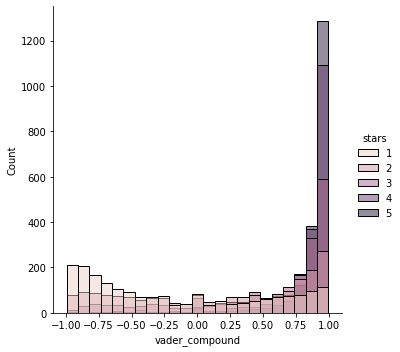

In [171]:
sns.displot(post_strat, x='vader_compound', hue='stars')

### Okay, let's rebuild our model using the better resampled data.

In [172]:
d = get_LDA(post_strat, 1000, 8, 30)



Topic #0: servic custom servic custom great excel distanc good social social distanc amaz thank place fast friend alway manag definit especi covid time patio experi nice love back enjoy clean recommend made littl


Topic #1: great love alway amaz place friend best recommend favorit servic come good restaur definit spot back tri high sushi awesom super famili also go one order get nice clean everyth


Topic #2: mask wear wear mask tabl distanc employe social seat covid server restaur us time social distanc one peopl go place back good walk order drink custom outsid dine went sit take great


Topic #3: pizza wing thai order sauc crispi spici best deliveri good fri cook great better perfect flavor definit place like tast love get extra even tri look ever noodl got made


Topic #4: order tast good like sauc flavor dish got place tri fri realli also pretti bland soup didnt much disappoint wasnt littl bit one get tast like spici price great restaur came


Topic #5: order wait call time ask

### Our groups look a little different, but let's see if our covid group (2) holds up to the previous model.

In [187]:
tdm = d['data'][3]
covid_topic = tdm.iloc[:,2]
# sort values
i = covid_topic.sort_values().tail().index.values
for review in post_strat.iloc[i].reviews: print (review, '\n')

I HATE that I'm giving Schmooze such a low rating because I actually really enjoy the place.  The food is great, the staff members are all very friendly and helpful.  Even the facility is very modern, sleek and artsy.  The problem is that it's always nearly impossible to get a seat inside because of the company's policies.  Schmooze allows people to come in, buy a single drink (or sometimes nothing at all), and then just hog one of the few available tables for hours on end.  The last 4 or 5 times I'd gone there single patrons were sitting at tables meant for four and they weren't even eating or drinking anything, just sitting around on their laptops while nearby couches sit empty.  It forces paying customers to have to sit outside and eat their lunches in 118' F degree temperatures.I'm all for allowing everybody to have a nice, leisurely dining experience but c'mon already.  This COVID stuff is already making things hard enough everyone all around, not just patrons but for all the smal

### Hmm, something doesn't seem quite right here. It doesn't seem to be capturing the same information as before.  If we see topic #0, it's clear some ofthe covid terms made it into a different group!

### It may be necessary to alter our topics a bit. Let's try increasing the range of features included in the model, and increasing the iterations of the LDA algorithm. This will give the algorithm more opportunities to 'sort' reviews into respective topics.

In [193]:
d = get_LDA(post_strat, 1250, 8, 30, 30)



Topic #0: servic custom servic custom great excel good amaz fast thank friend alway place especi manag definit time recommend price covid love experi made back better enjoy nice bad tasti clean spot


Topic #1: love great alway place amaz best friend recommend favorit servic come restaur good sushi definit spot tri back high awesom famili one go super also order get ive everyth nice


Topic #2: mask wear wear mask distanc social social distanc tabl employe covid peopl restaur place seat go time one good server back custom pandem clean great take walk busi care order dine us


Topic #3: pizza wing thai order crispi sauc best deliveri cook spici good great perfect flavor fri better definit get love like place tast even tri extra look larg arriv ever ive


Topic #4: order tast like good sauc flavor dish got fri tri place also realli soup bland spici didnt much disappoint wasnt thai one littl tast like get price noodl small piec great


Topic #5: order wait us call time ask minut get pla

### That looks a lot better--let's check out our top five for topic #2.

In [194]:
tdm = d['data'][3]
covid_topic = tdm.iloc[:,2]
# sort values
i = covid_topic.sort_values().tail().index.values
for review in post_strat.iloc[i].reviews: print (review, '\n')

Went here for dinner two Sundays ago with friends who were in town for the weekend.  It was our first time eating in a restaurant since the whole COVID thing started.  The hostess greeted and seated us on time, wearing a mask.  That's as far as the mask wearing went.  Servers, bussers, bartenders, and (assuming) cooks were not masked.  None of them.  Server grabbed the top of my glass to refill with water (there was no straw).  Ugh!  This is restaurant management 101, even when COVID isn't going on.  Why do so many servers do it?!   Servers were also clearing dirty dishes and then delivering cocktails to the next table.  Should not be happening.  Servers server, busser bus.On a positive note, food and cocktails were delish...way better than expected for a touristy-ish restaurant!  We had been told not to go by another friend.  If times were different right now and COVID wasn't a thing, I would have given them 4-5 stars for food, service (less the cross contamination of my glass...that'

### This looks promising! Notice how there seems to be a lot of negative sentiment surrounding these representative samples, too.

# Looking at Top Topics

### One way we can explore our data is to see the top topics for our model. Let's see what we have...

In [195]:
df = d['data'][0].copy()
tdm = d['data'][3]
df['topic'] = tdm.apply(lambda x: tdm.columns[x.argmax()], axis=1)
df.topic.value_counts()

5    2340
4    2197
6    1700
1    1585
7    1142
2     659
0     200
3     177
Name: topic, dtype: int64

### Interestingly, it looks like the top topics don't include our Covid topic; but that's okay! Remember that LDA makes it so every part of the text is assigned <i>some</i> weight. It may be worth lookingat the top three topics: 

In [199]:
d['topics'][5]

['order',
 'wait',
 'us',
 'call',
 'time',
 'ask',
 'minut',
 'get',
 'place',
 'said',
 'told',
 'go',
 'servic',
 'back',
 'didnt',
 'one',
 'even',
 'restaur',
 'got',
 'custom',
 'hour',
 'want',
 'never',
 'take',
 'rude',
 'dont',
 'tabl',
 'busi',
 'drink',
 'come']

This one makes sense that the majority would fall into this--most keywords have to do with 'eating out', with a trend toward negative given words like 'didn't', 'don't', and 'rude'.

In [200]:
d['topics'][4]

['order',
 'tast',
 'like',
 'good',
 'sauc',
 'flavor',
 'dish',
 'got',
 'fri',
 'tri',
 'place',
 'also',
 'realli',
 'soup',
 'bland',
 'spici',
 'didnt',
 'much',
 'disappoint',
 'wasnt',
 'thai',
 'one',
 'littl',
 'tast like',
 'get',
 'price',
 'noodl',
 'small',
 'piec',
 'great']

Same goes here--notice the food related and sentiment related words, such as 'tast like', 'soup', and 'get'. Additionally, this seems to trend with positive sentiment. 

### So far, our top topics are picking up on: (food + positive) & (customer service + negative). 

## Using top LDA topics to predict continuous sentiment values.

With our lda topics in hand, let's see how well they predict sentiment values using linear regression!

In [205]:
tdm['sentiment'] = df.vader_compound
# let's set a sentiment column
tdm.head()

,0,1,2,3,4,5,6,7,sentiment
0,0.030864,0.030831,0.030832,0.030801,0.030824,0.784160,0.030856,0.030832,0.7003
1,0.042314,0.042339,0.042369,0.042316,0.042347,0.703570,0.042400,0.042344,-0.4588
2,0.034541,0.034613,0.034566,0.034559,0.034650,0.757901,0.034595,0.034576,-0.7959
3,0.742268,0.036813,0.036826,0.036703,0.036830,0.036773,0.036771,0.037016,0.3622
4,0.024902,0.024944,0.025049,0.024907,0.024943,0.068897,0.781395,0.024963,0.5434


### For this model, topics will be the predictor, and sentiment will be the dependent variable. Let's see how we do...

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

dependant = 'sentiment'
y = tdm[dependant]
X = tdm.drop(columns=dependant).values
    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=0)
clf = LinearRegression().fit(X_train,y_train)
clf.score(X_test, y_test)

0.1812918776607364

Yikes--not great! But we're using lots of topics. Let's see what happens when we reduce the number of topics to only those that show obvious sentiment leaning:

In [213]:
tdm.iloc[:,[2,5]].values

array([[0.03083197, 0.78415997],
       [0.04236926, 0.70357006],
       [0.03456649, 0.7579007 ],
       ...,
       [0.20824591, 0.03352714],
       [0.01983556, 0.01985057],
       [0.03153268, 0.03155011]])

In [222]:
y = tdm[dependant]
X = tdm.iloc[:,[5,4,6]].values
    
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=0)
clf = LinearRegression().fit(X_train,y_train)
clf.score(X_test, y_test)

0.13643212385663905

#### Not great! Perhaps we can represent the sentiment in terms of categorical data?

## Research Question 1:  Using Top LDA topics as predictors for sentiment categories with Logistic Regression

  
In this step, we can convert the continuous scores for sentiment to build a predictive model via logisitic regression. To convert the values, we can apply a custom function defined below, which returns values corresponding to 'negative', neutral', or 'positive' based on the rule of thumb defined on the creator of vader sentiment's github page.

In [223]:
def get_sentiment(x):
    '''Assumes x is a sentiment score derived using the VADER library. Returns labels'''
    if x < -0.5:
        return 'negative'
    if x > 0.5:
        return 'positive'
    else:
        return 'neutral'

tdm['sentiment'] = tdm.sentiment.apply(get_sentiment)

In [225]:
dependant = 'sentiment'
y = tdm[dependant]
X = tdm.drop(columns=dependant).values

In [240]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=0)
clf = LogisticRegression().fit(X_train,y_train)
clf.score(X_test, y_test)

0.6392

That's much better!

### Clustering Using Pairplots
  
#### One last observation might be revealed using pairplots; however, the data captured here is limited due to the very low values captured  by LDA.

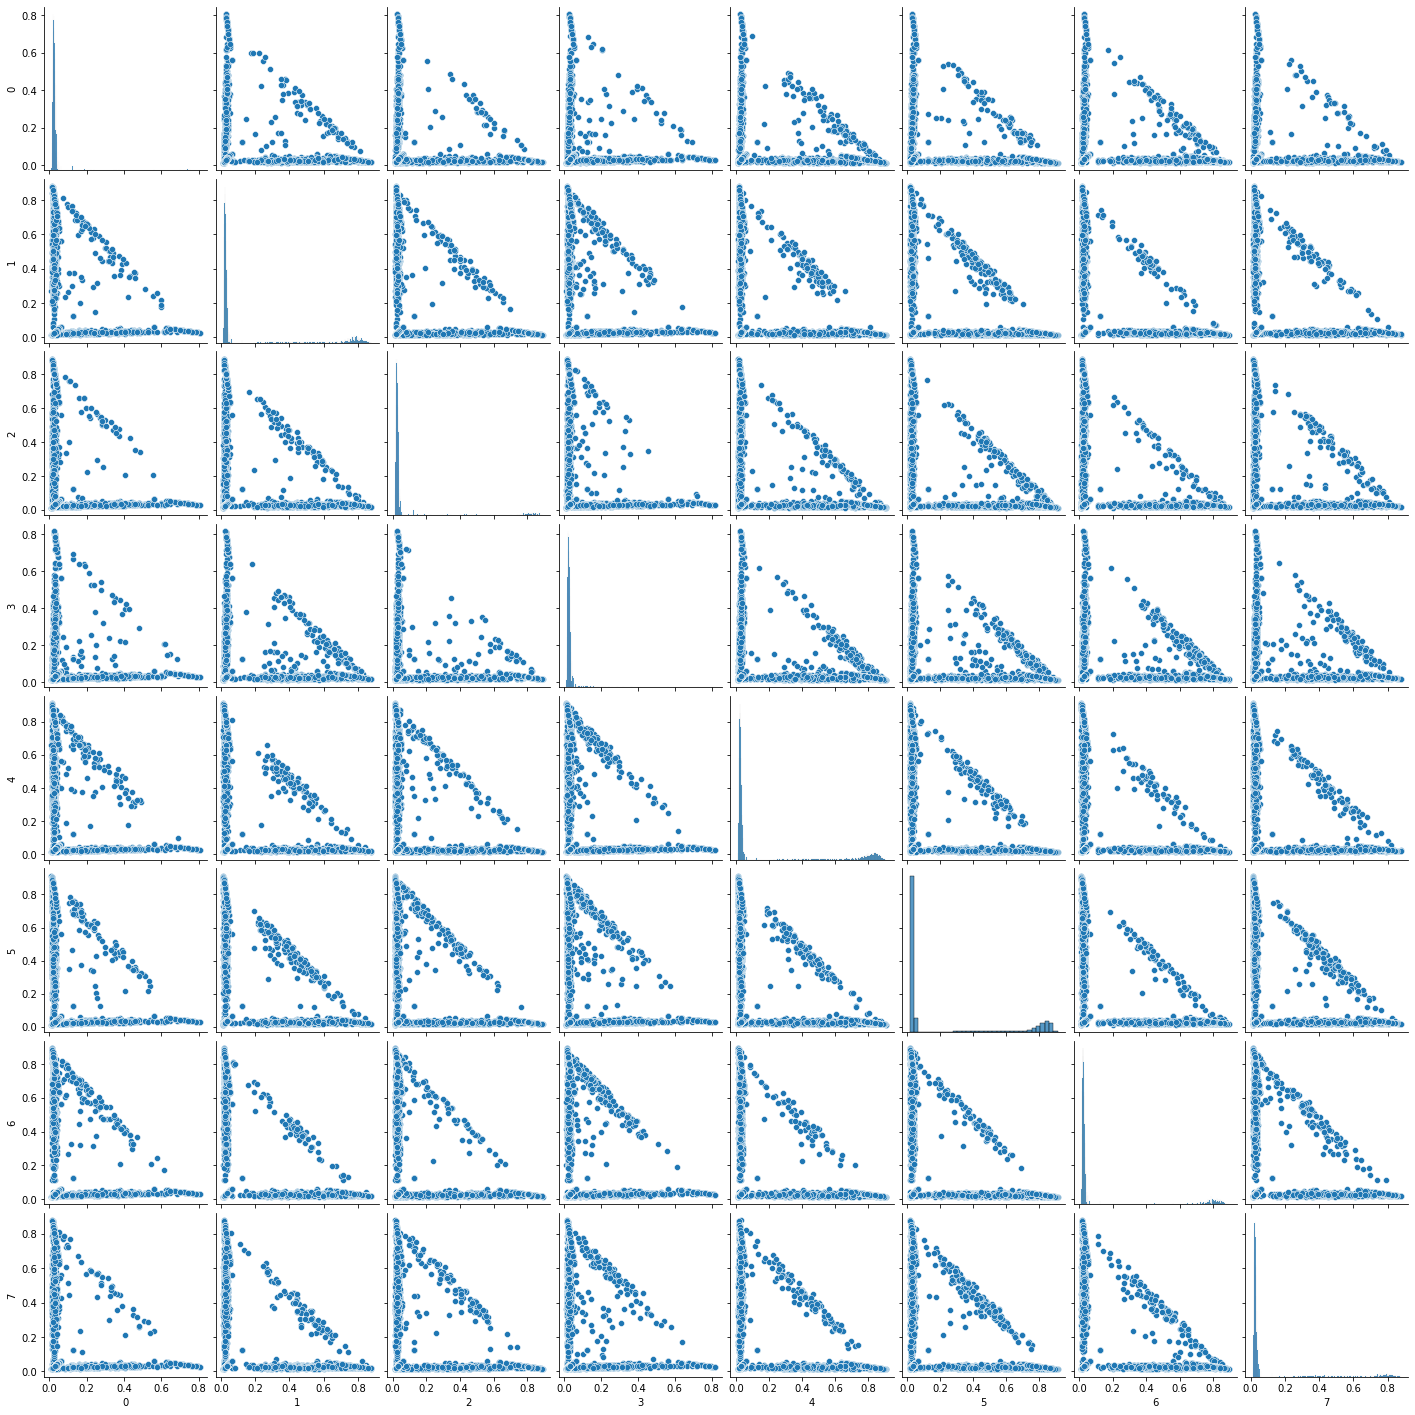

In [243]:
sns.pairplot(tdm)

## Research Question 2: Heatmap showing Kendall Tau Ordered Correlation

In the below heatmap, we might be able to see relationships between ordered pairs of topics. From the model below, we can see that the order of the COVID group (2) is highly correlated with the order of topic (0). 
  
  
### This implies that the position of COVID related terms tend to covary with those of "customer service" related terms. That is, when COVID terms are important, so too are customer service terms.

<AxesSubplot:>

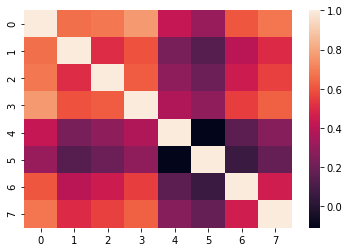

In [238]:
sns.heatmap(tdm.iloc[:,:-1].apply(lambda x: np.log(x+.01), axis=1).corr(method="kendall"))

# Part Four: Conclusion and Sources

### I have arrived at a few conclusions given this project:

1. <b>Topic extraction via LDA seems to be a reliable way to capture textual information.</b> While this algorithm and model certainly requires further validation, the initial results are coherent--and reveal interesting connections between terms and how reviews were grouped. Additionally, a lot of the validation for this model depends on manual inspection--which I really enjoyed (but could get tedious sometimes when the topics were non-sensical). 
  
  
2. <b>Topic weights can be a reliable predictor of VADER sentiment using Logistic Regression.</b> There are few caveats here: I expect that the predictors certainly included features that innately skewed the model towards sentiment (i.e. frequent highly loaded sentiment words, such as 'good', 'bad' and 'terrible'.). However, several indicators indentified in previous studies (see: Proposal) are present here, too, such as: 'food', 'service', and 'atmosphere'. Had I more time with this project, I would love to validate these topics and assign more discrete labels for each column. 
  
  
3. <b>Topic weights are highly correlated as ordered variables</b>. Looking at the heatmap, there's a lot to be investigated about the correlations between ordered pairs. I would really like to investigate this further, given the opportunity.
  
  
4. <b>Finally, perhaps the most signifcant conclusion derived from this project is the fact that reserach on natural language takes a lot of time up front for pre-processing and tending to your data.</b> There was a significant amount of time sunk into making this data useable--for future considerations, I will likely try to use a more widely available dataset for my projects!

### Sources:

#### LDA and tifidf:
  
Check out Alice Zhaou's amazing videos on using nltk and LDA:https://www.youtube.com/watch?v=NYkbqzTlW3w&t=958s&ab_channel=AliceZhao
  
  
A good amount of code implementation was sourced from sklearn's documentation.
  
  
Additionally, several assumptions about this project are derived from the sources included in the project proposal. 